In [1]:
import sys, os

from h5flow.data import dereference

layout_file = 'geo/layout-2.4.0.yaml'

vdrift = 1.5136504594138773 # mm/us for 0.5kV/cm

## Plotting Functions

In [2]:
from collections import defaultdict
import yaml
import numpy as np

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from collections import defaultdict

import plotly.graph_objects as go
import plotly.express as px

import pandas as pd

def _rotate_pixel(pixel_pos, tile_orientation):
    return pixel_pos[0]*tile_orientation[2], pixel_pos[1]*tile_orientation[1]

def load_tile_geometry(fpath):
    '''
    Build a dictionary for position lookup from tile layout.
 
    Arguments
    ---------
    fpath : str
        file path to the tile layout
    
    Returns
    -------
    geometry : dict
        dictionary of tile position in mm
        `geometry[(chip, channel)] -> (x,y,z)`   
    '''
    with open(fpath, 'r') as f:
        geometry_yaml = yaml.load(f, Loader=yaml.FullLoader)
          
    chips = geometry_yaml["chips"]
    pixels = geometry_yaml["pixels"]

    geometry = defaultdict(lambda: (None, None, None))
    
    for chip, channels in chips:
        for channel_id, channel in enumerate(channels):
            if channel is not None:
                x = pixels[channel][1]
                y = pixels[channel][2]
                z = 0
                geometry[(chip, channel_id)] = x, y, z

    return dict(geometry)

def packet_to_eventid(assn, tracks):
    '''
    Assoiciate packet to eventID.
    
    Arguments
    ---------
    assn : array_like
        packet to track association (`mc_packets_assn`) from `larnd-sim` output
        
    tracks: array_like
        list of track segments
        
    Returns
    -------
    event_ids: ndarray (N,)
        array of eventID.
        `len(event_ids)` equals to `len(packets)`
    '''
    track_ids = assn['track_ids'].max(axis=-1)
    
    event_ids = np.full_like(track_ids, -1, dtype=int)
    mask = track_ids != -1
    event_ids[mask] = tracks['eventID'][track_ids[mask]]
    
    return event_ids

def draw_anode_cathode_planes(geom, **kwargs):
    '''
    Draw two anode planes for module0.
    
    TODO(2021-11-09 kvt) for other detector geometry?
    
    Arguments
    ---------
    geom : dict
        tile geometry from `load_tile_geometry()`
    
    **kwargs :
        additional keyword arguments passed to `Surface`
        
    Returns
    -------
    traces: list(Scatter3d)
        plolty Surface objects
    '''

    pos = np.array(list(geom.values())) / 10.
    # print("pos, ", pos[:, 0])
    # # mask = pos[:,2] > 0
    traces = []
    
    for i in range(2):
        x = np.array([pos[:, 0].min(), pos[:, 0].max()])
        y = np.array([pos[:, 1].min(), pos[:, 1].max()])
        if i == 0:
            z = np.full((2,2), 0)
        elif i == 1:
            z = np.full((2,2), 30)

        traces.append(go.Surface(x=x, y=y, z=z, **kwargs))
    
    return traces


def plot_hit_raw_reco3d(hits, geom, vdrift, **kwargs):
    
    n_hits = len(hits)
    x_reco = np.empty(n_hits, dtype=float)
    y_reco = np.empty_like(x_reco)
    z_reco = np.empty_like(x_reco)
    q_reco = np.empty_like(x_reco)
    
    t0 = min(hits['ts'])

    for i, hit in enumerate(hits):

        key = (hit['chipid'], hit['channelid'])

        x_reco[i], y_reco[i] = geom.get(key)[:2]
        
        t = hit['ts'] - t0
        
        z_reco[i] = vdrift * t * 0.1
        q_reco[i] = 1     
     
    # to cm
    x_reco /= 10
    y_reco /= 10
               
    trace = go.Scatter3d(
        x=x_reco, y=y_reco, z=z_reco,
        marker_color=q_reco,
        **kwargs
    )
    
    return trace

def plot_hits_reco3d(hits, vdrift, t0, **kwargs):
  
#     t0 = np.min(hits['ts'])    
     
    # to cm
    x_reco = hits['px'] / 10
    y_reco = hits['py'] / 10
    # the first / 10 converts time tick to us (at 10MHz each tick 0.1us)
    # the second / 10 converts mm to cm
    z_reco = (hits['ts'] - t0) / 10 * vdrift / 10 
    q_reco = hits['q']
    
    trace = go.Scatter3d(
        x=x_reco.flatten(), y=y_reco.flatten(), z=z_reco.flatten(),
        marker_color=q_reco.flatten(),
        **kwargs
    )
    
    return trace

def plot_track_reco3d(track, **kwargs):
     
    # to cm
    x_reco = track['trajectory'][0][:, 0] /10
    y_reco = track['trajectory'][0][:, 1] /10
    z_reco = track['trajectory'][0][:, 2] /10 

    dqdx = []

    for i in range(len(track['dq'][0])):
        this_dx = track['dx'][0][i] 
        dx = np.sqrt(this_dx[0] * this_dx[0] + this_dx[1] * this_dx[1] + this_dx[2] * this_dx[2]) / 10 # mm to cm
        dq = track['dq'][0][i]
        if dx != 0:
            dqdx.append(dq/dx)
        else:
            dqdx.append(0)
        
    trace = go.Scatter3d(
        x=x_reco.flatten(), y=y_reco.flatten(), z=z_reco.flatten(),
        line_color=dqdx,
        **kwargs
    )
    
    return trace

def plot_track_ends(track_start, track_end, **kwargs):
    '''
    Plot tracks. Segments are jointed by straight line.
    
    Arguments
    ---------
    tracks : array_like
        A list of track segements.
        
    **kwargs:
        additional keyword arguments passed to `Scatter3d``
        
    Returns
    -------
    trace: Scatter3d
        plolty trace object
    '''
    track_start = track_start[0]
    track_end = track_end[0]
    
    x = [track_start[0]/10, track_end[0]/10]
    y = [track_start[1]/10, track_end[1]/10]
    z = [track_start[2]/10, track_end[2]/10]
    
    trace = go.Scatter3d(x=x, y=y, z=z, **kwargs)
    
    return trace

In [21]:
import h5py
import matplotlib.pyplot as plt
import glob
import itertools

geom = load_tile_geometry(layout_file)
path = "/sdf/group/neutrino/larpix/evd/selftrigger/2022-07-30/"
fname = "selftrigger_2022_07_30_23_57_23_PDT_evd.h5"

f = h5py.File(path + fname, 'r')
for key in f.keys():
    print(key)

charge
combined
geometry_info
lar_info
run_info


In [22]:
events = f['charge/events/data']
print(np.unique(events['id']))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

trk_pool [132]
132
dq/dx:  4699.561872853795
dq/dx:  0
dq/dx:  0
dq/dx:  0
dq/dx:  0
dq/dx:  0
dq/dx:  0
[[-90.89700317382812 -98.0099410413086 6.842098039591124]]
[[-82.41271837718037 -100.62383039797147 1.323203657705704]]


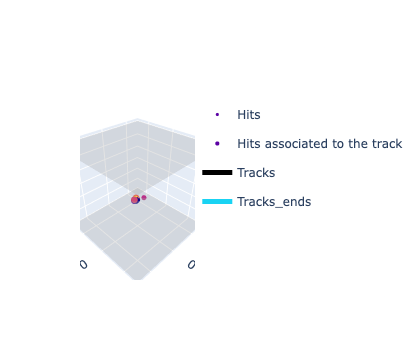

In [32]:
i_ev = 84

fig = go.Figure()

pos = np.array(list(geom.values())) / 10.

xmin = pos[:, 0].min()
xmax = pos[:, 0].max()
        
ymin = pos[:, 1].min()
ymax = pos[:, 1].max()
       
# -----------------------------------------------------------------------------
# Draw anode planes
# -----------------------------------------------------------------------------
fig.add_traces(draw_anode_cathode_planes(
    geom,
    showscale=False,
    opacity=0.3,
    colorscale='Greys',
))

# -----------------------------------------------------------------------------
# Plot hits in event
# -----------------------------------------------------------------------------

hits_ev = dereference(i_ev, ref=f['charge/events/ref/charge/hits/ref'], region=f['charge/events/ref/charge/hits/ref_region'], data=f['charge/hits/data'])
t0 = min(hits_ev['ts'][0])
traces_hits_ev = []
traces_hits_ev.append(plot_hits_reco3d(
    hits_ev, 
    vdrift = vdrift, 
    t0 = t0,
    showlegend=True,
    legendgroup='Hits',
    mode='markers',
    marker_size=3.))
traces_hits_ev[0].update(showlegend=True, name='Hits')
fig.add_traces(traces_hits_ev)

# -----------------------------------------------------------------------------
# Plot track in event
# -----------------------------------------------------------------------------

tracks_ev = dereference(i_ev, ref=f['charge/events/ref/combined/tracklets/ref'], region=f['charge/events/ref/combined/tracklets/ref_region'], data=f['combined/tracklets/data'])
trk_pool = tracks_ev['id'][0]

traces_tracks_ev = []
traces_tracks_ends_ev = []
traces_hits_trk = []

for trk_id in trk_pool:
    print(trk_id)
    if np.ma.is_masked(trk_id):
        print("no valid tracks")
        continue
        
    ###############
    # Plot track segments
    ###############
    mask = tracks_ev['id'] == trk_id
    this_trk = tracks_ev[mask]

    traces_tracks_ev.append(plot_track_reco3d(
        this_trk, 
        showlegend=True,
        legendgroup='Tracks',
        marker_size=3.,
        line_width = 5.
    ))
    
    ###############
    # Plot track ends
    ###############
    track_start = this_trk['start']
    track_end = this_trk['end']

    traces_tracks_ends_ev.append(plot_track_ends(
        track_start,
        track_end,
        showlegend=True,
        legendgroup='Track_ends',
        marker_size=3.,
        line_width = 5.
    ))
    
    ###############
    # Plot hits in track
    ###############
    hits_trk = dereference(trk_id, ref=f['combined/tracklets/ref/charge/hits/ref'], region=f['combined/tracklets/ref/charge/hits/ref_region'], data=f['charge/hits/data'])

    traces_hits_trk.append(plot_hits_reco3d(
        hits_trk, 
        vdrift = vdrift, 
        t0 = t0,
        showlegend=True,
        legendgroup='Hits associated to the track',
        mode='markers',
        marker_size=4.))

if len(traces_hits_trk) > 0:
    traces_hits_trk[0].update(showlegend=True, name='Hits associated to the track')
    fig.add_traces(traces_hits_trk)

if len(traces_tracks_ev) > 0:
    traces_tracks_ev[0].update(showlegend=True, name='Tracks')
    fig.add_traces(traces_tracks_ev)

if len(traces_tracks_ends_ev) > 0:
    traces_tracks_ends_ev[0].update(showlegend=True, name='Tracks_ends')
    fig.add_traces(traces_tracks_ends_ev)


fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[xmin,xmax],),
        yaxis = dict(nticks=4, range=[ymin,ymax],)
    ))

fig.show()
                   